# covid-19 death risk analysis 
The dataset was provided by the Mexican government. This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

Downloaded from [Kaggle.com](https://www.kaggle.com/datasets/meirnizri/covid19-dataset).


In [370]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

In [275]:
df = pd.read_csv('covid.csv')

In [276]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

## Understanding and cleaning the data

### Helpers

In [278]:
def plot_hist_col(col: str, title: str, kde=True, bins=30) -> None:
  plt.title(title)
  sns.histplot(data=df, x=col, bins=bins, kde=kde)
  plt.show()

In [279]:
def plot_col_deaths_hist(label: str) -> None:
    plt.hist(df[df["DIED"] == 1][label], color="red", label="died", alpha=0.7, density=True)
    plt.hist(df[df["DIED"] == 0][label], color="green", label="not died", alpha=0.7, density=True)
    plt.legend()
    plt.show()

In [280]:
def plot_pie_tf(title, column, labels):
  data = [
      len(df[df[column] == 0]),
      len(df[df[column] == 1])
  ]
  colors = sns.color_palette('pastel')[2:4]
  plt.figure(figsize=(7,7))
  plt.title(title)
  plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
  plt.show()

### Column `DATE_DIED`

If the patient died indicate the date of death, and 9999-99-99 otherwise.

In [281]:
df['DATE_DIED'].describe()

count        1048575
unique           401
top       9999-99-99
freq          971633
Name: DATE_DIED, dtype: object

In [282]:
df['DIED'] = df['DATE_DIED'].apply(lambda x: 0 if x == '9999-99-99' else 1)
df.drop(labels='DATE_DIED', axis=1, inplace=True)
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DIED
0,2,1,1,1,97,1,65,2,2,2,...,2,1,2,2,2,2,2,3,97,1
1,2,1,2,1,97,1,72,97,2,2,...,2,1,2,2,1,1,2,5,97,1
2,2,1,2,2,1,2,55,97,1,2,...,2,2,2,2,2,2,2,3,2,1
3,2,1,1,1,97,2,53,2,2,2,...,2,2,2,2,2,2,2,7,97,1
4,2,1,2,1,97,2,68,97,1,2,...,2,1,2,2,2,2,2,3,97,1


In [283]:
def plot_deaths():
  labels=['not dead', 'dead']
  data = [
      len(df[df['DIED'] == 0]),
      len(df[df['DIED'] == 1])
  ]
  colors = sns.color_palette('pastel')[2:4]
  plt.figure(figsize=(7,7))
  plt.title('the percentage of deaths in the dataset')
  plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
  plt.show()

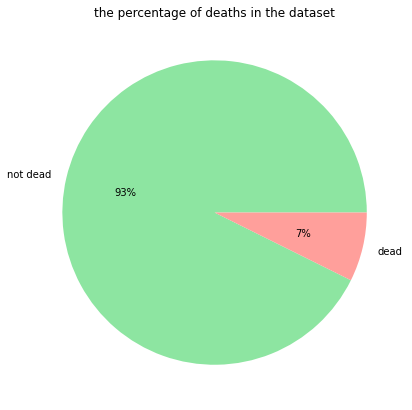

In [284]:
plot_deaths()

### Column `SEX`
1 for female and 2 for male

In [285]:
df['SEX'].value_counts(dropna=False)

1    525064
2    523511
Name: SEX, dtype: int64

In [286]:
df['IS_FEMALE'] = df['SEX'].apply(lambda x: 0 if x == 2 else 1)
df.drop(labels='SEX', axis=1, inplace=True)
df.head()

,USMER,MEDICAL_UNIT,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,...,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DIED,IS_FEMALE
0,2,1,1,97,1,65,2,2,2,2,...,1,2,2,2,2,2,3,97,1,1
1,2,1,1,97,1,72,97,2,2,2,...,1,2,2,1,1,2,5,97,1,0
2,2,1,2,1,2,55,97,1,2,2,...,2,2,2,2,2,2,3,2,1,0
3,2,1,1,97,2,53,2,2,2,2,...,2,2,2,2,2,2,7,97,1,1
4,2,1,1,97,2,68,97,1,2,2,...,1,2,2,2,2,2,3,97,1,0


In [287]:
df[df['DIED'] == 1].groupby(['IS_FEMALE'])['IS_FEMALE'].count()

IS_FEMALE
0    49540
1    27402
Name: IS_FEMALE, dtype: int64

**Observation:** women die less frequently.

### Column `AGE`

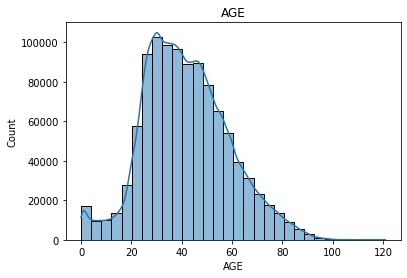

In [288]:
plot_hist_col('AGE', 'AGE')

**Observation:** The dataset mostly consists of people between 25 and 50 years old.

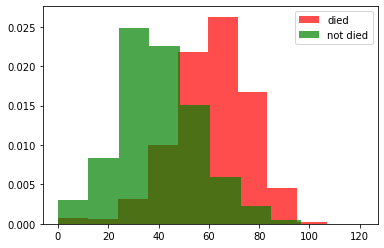

In [289]:
plot_col_deaths_hist('AGE')

**Observation:** People older than 50, are at risk.

### Column `CLASIFFICATION_FINAL`

Values 1-3 mean that the patient was diagnosed with covid in different
degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.

In [290]:
df['CLASIFFICATION_FINAL'].describe()

count    1.048575e+06
mean     5.305653e+00
std      1.881165e+00
min      1.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      7.000000e+00
max      7.000000e+00
Name: CLASIFFICATION_FINAL, dtype: float64

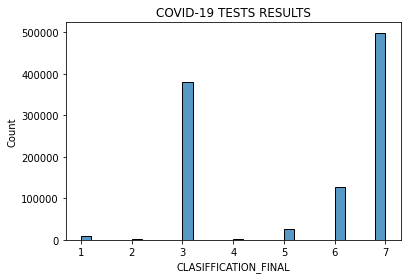

In [291]:
plot_hist_col('CLASIFFICATION_FINAL', 'COVID-19 TESTS RESULTS', kde=False)

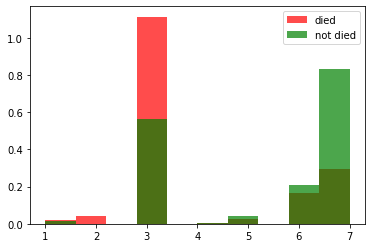

In [292]:
plot_col_deaths_hist('CLASIFFICATION_FINAL')

### Column `PATIENT_TYPE`

Type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.

In [293]:
df['PATIENT_TYPE'].describe()

count    1.048575e+06
mean     1.190765e+00
std      3.929041e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.000000e+00
Name: PATIENT_TYPE, dtype: float64

In [294]:
df['HOSPITALIZATION'] = df['PATIENT_TYPE'].apply(lambda x: 1 if x == 2 else 0)
df.drop(labels='PATIENT_TYPE', axis=1, inplace=True)

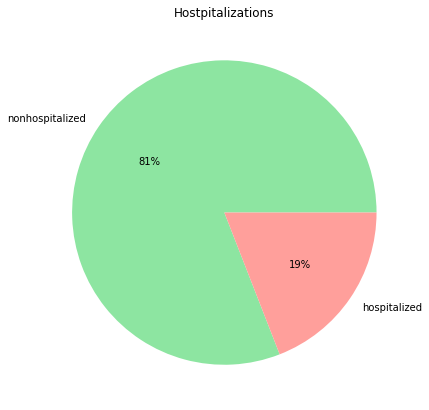

HOSPITALIZATION
0    848544
1    200031
Name: HOSPITALIZATION, dtype: int64


In [295]:
plot_pie_tf('Hostpitalizations', 'HOSPITALIZATION', ['nonhospitalized', 'hospitalized'])
print(df.groupby(['HOSPITALIZATION'])['HOSPITALIZATION'].count())

**Observation:** Most of the people in the dataset hadn't been hospitalized.

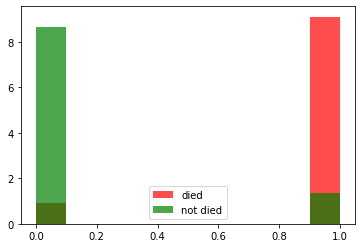

In [296]:
plot_col_deaths_hist('HOSPITALIZATION')

In [297]:
df[df['DIED'] == 1].groupby(['HOSPITALIZATION'])['HOSPITALIZATION'].count()

HOSPITALIZATION
0     6876
1    70066
Name: HOSPITALIZATION, dtype: int64

**Observation:** Most of the patients died.

### Column `PNEUMONIA`

Whether the patient already has air sac inflammation or not.

In [298]:
df['PNEUMONIA'].value_counts()

2     892534
1     140038
99     16003
Name: PNEUMONIA, dtype: int64

In [299]:
df = df[df['PNEUMONIA'] != 99]
df['PNEUMONIA'].value_counts()

2    892534
1    140038
Name: PNEUMONIA, dtype: int64

In [300]:
df['PNEUMONIA'].value_counts()
df['PNEUMONIA'] = df['PNEUMONIA'].apply(lambda x: 0 if x == 2 else 1)

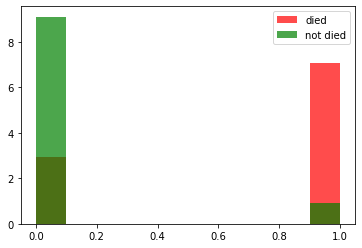

In [301]:
plot_col_deaths_hist('PNEUMONIA')

**Observation:** Most of the people that had suffered pneumonia died. 

### Column `PREGNANT`

Whether the patient is pregnant or not.

In [302]:
df['PREGNANT'].value_counts()

97    516154
2     505159
1       7870
98      3389
Name: PREGNANT, dtype: int64

Most of the data is missing in this column, it should be dropped.

In [303]:
df.drop(labels=['PREGNANT'], axis=1, inplace=True)

### Column `DIABETES`

Whether the patient has diabetes or not.

In [304]:
df['DIABETES'].value_counts()

2     905856
1     123395
98      3321
Name: DIABETES, dtype: int64

In [305]:
df = df[df['DIABETES'] != 98]
df['DIABETES'] = df['DIABETES'].apply(lambda x: 0 if x == 2 else 1)

In [306]:
df['DIABETES'].value_counts()

0    905856
1    123395
Name: DIABETES, dtype: int64

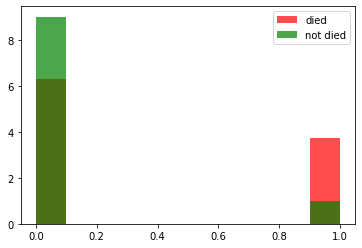

In [307]:
plot_col_deaths_hist('DIABETES')

**Observation:** Most of the people that had been diagnosed with diabetes died.

### Column `COPD`

Indicates whether the patient has Chronic obstructive pulmonary disease or not.

In [308]:
df['COPD'].value_counts()

2     1014380
1       14507
98        364
Name: COPD, dtype: int64

In [309]:
df = df[df['COPD'] != 98]
df['COPD'] = df['COPD'].apply(lambda x: 0 if x == 2 else 1)

In [310]:
df['COPD'].value_counts()

0    1014380
1      14507
Name: COPD, dtype: int64

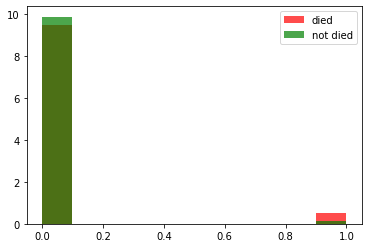

In [311]:
plot_col_deaths_hist('COPD')

**Observation**: Most of the people that had been suffering from Chronic obstructive pulmonary disease died.

### Column `ASTHMA`

Whether the patient has asthma or not.

In [312]:
df['ASTHMA'].value_counts()

2     998084
1      30623
98       180
Name: ASTHMA, dtype: int64

In [313]:
df = df[df['ASTHMA'] != 98]
df['ASTHMA'] = df['ASTHMA'].apply(lambda x: 0 if x == 2 else 1)

In [314]:
df['ASTHMA'].value_counts()

0    998084
1     30623
Name: ASTHMA, dtype: int64

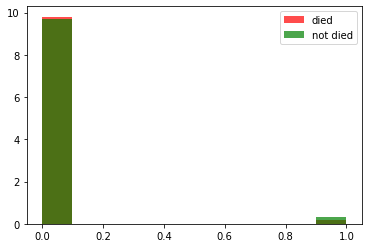

In [315]:
plot_col_deaths_hist('ASTHMA')

In [316]:
df[df['ASTHMA'] == 1].groupby(['DIED'])['DIED'].count()

DIED
0    29169
1     1454
Name: DIED, dtype: int64

In [317]:
df[df['ASTHMA'] == 0].groupby(['DIED'])['DIED'].count()

DIED
0    924191
1     73893
Name: DIED, dtype: int64

In [318]:
df.drop(labels=['ASTHMA'], axis=1, inplace=True)

**Observation:** Asthma isn't correlated with death risk.

### Column `INMSUPR`

Whether the patient is immunosuppressed or not.

In [319]:
df['INMSUPR'].value_counts()

2     1014482
1       13717
98        508
Name: INMSUPR, dtype: int64

In [320]:
df = df[df['INMSUPR'] != 98]
df['INMSUPR'] = df['INMSUPR'].apply(lambda x: 0 if x == 2 else 1)

In [321]:
df['INMSUPR'].value_counts()

0    1014482
1      13717
Name: INMSUPR, dtype: int64

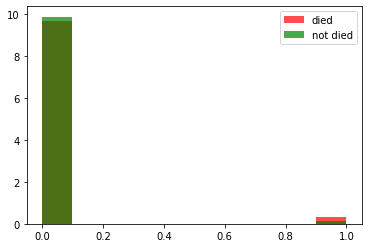

In [322]:
plot_col_deaths_hist('INMSUPR')

**Observation:** Immunosuppressed patients are at risk.

### Column `HIPERTENSION`

Whether the patient has hypertension or not.

In [323]:
df['HIPERTENSION'].value_counts()

2     867697
1     160278
98       224
Name: HIPERTENSION, dtype: int64

In [324]:
df = df[df['HIPERTENSION'] != 98]
df['HIPERTENSION'] = df['HIPERTENSION'].apply(lambda x: 0 if x == 2 else 1)
df['HIPERTENSION'].value_counts()

0    867697
1    160278
Name: HIPERTENSION, dtype: int64

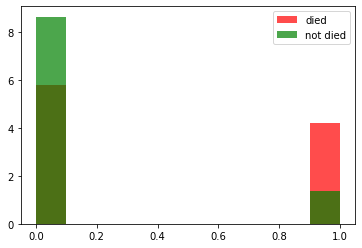

In [325]:
plot_col_deaths_hist('HIPERTENSION')

**Observation:** Patients with hypertension are at risk.

### Column `CARDIOVASCULAR`

Whether the patient has heart or blood vessels related disease.

In [326]:
df['CARDIOVASCULAR'].value_counts()

2     1007507
1       20254
98        214
Name: CARDIOVASCULAR, dtype: int64

In [327]:
df = df[df['CARDIOVASCULAR'] != 98]
df['CARDIOVASCULAR'] = df['CARDIOVASCULAR'].apply(lambda x: 0 if x == 2 else 1)
df['CARDIOVASCULAR'].value_counts()

0    1007507
1      20254
Name: CARDIOVASCULAR, dtype: int64

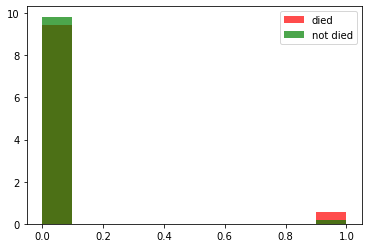

In [328]:
plot_col_deaths_hist('CARDIOVASCULAR')

**Observation:** Patients with heart or blood vessels related diseases are at risk.

### Column `RENAL_CHRONIC`

Whether the patient has chronic renal disease or not.

In [329]:
df['RENAL_CHRONIC'].value_counts()

2     1009157
1       18445
98        159
Name: RENAL_CHRONIC, dtype: int64

In [330]:
df = df[df['RENAL_CHRONIC'] != 98]
df['RENAL_CHRONIC'] = df['RENAL_CHRONIC'].apply(lambda x: 0 if x == 2 else 1)
df['RENAL_CHRONIC'].value_counts()

0    1009157
1      18445
Name: RENAL_CHRONIC, dtype: int64

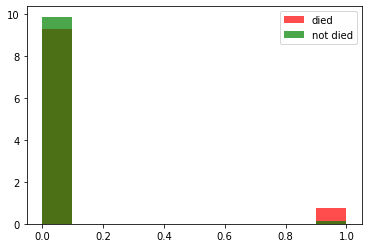

In [331]:
plot_col_deaths_hist('RENAL_CHRONIC')

**Observation:** Patients with chronic renal disease are at risk.

### Column `OTHER_DISEASE`

Whether the patient has other disease or not.

In [332]:
df['OTHER_DISEASE'].value_counts()

2     998733
1      27157
98      1712
Name: OTHER_DISEASE, dtype: int64

In [333]:
df = df[df['OTHER_DISEASE'] != 98]
df['OTHER_DISEASE'] = df['OTHER_DISEASE'].apply(lambda x: 0 if x == 2 else 1)
df['OTHER_DISEASE'].value_counts()

0    998733
1     27157
Name: OTHER_DISEASE, dtype: int64

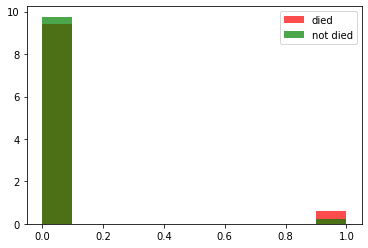

In [334]:
plot_col_deaths_hist('OTHER_DISEASE')

**Observation:** Patients with other diseases are at risk.

### Column `OBESITY`

Whether the patient is obese or not.

In [335]:
df['OBESITY'].value_counts()

2     868413
1     157104
98       373
Name: OBESITY, dtype: int64

In [336]:
df = df[df['OBESITY'] != 98]
df['OBESITY'] = df['OBESITY'].apply(lambda x: 0 if x == 2 else 1)
df['OBESITY'].value_counts()

0    868413
1    157104
Name: OBESITY, dtype: int64

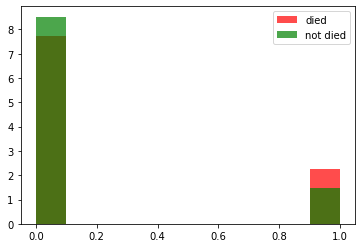

In [337]:
plot_col_deaths_hist('OBESITY')

**Observation**: Obese patients are at risk.

### Column `TOBACCO`

Whether the patient is a tobacco user.

In [338]:
df['TOBACCO'].value_counts()

2     942477
1      82675
98       365
Name: TOBACCO, dtype: int64

In [339]:
df = df[df['TOBACCO'] != 98]
df['TOBACCO'] = df['TOBACCO'].apply(lambda x: 0 if x == 2 else 1)
df['TOBACCO'].value_counts()

0    942477
1     82675
Name: TOBACCO, dtype: int64

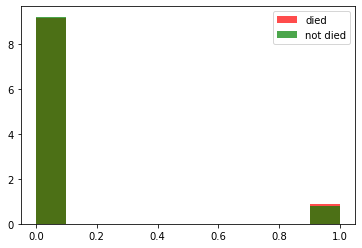

In [340]:
plot_col_deaths_hist('TOBACCO')

**Observation**: Smoking isn't highly correlated with death.

### Column `USMER`

Indicates whether the patient treated medical units of the first, second or third level.

In [341]:
df['USMER'].value_counts()

2    658255
1    366897
Name: USMER, dtype: int64

In [342]:
df['USMER'] = df['USMER'].apply(lambda x: 0 if x == 2 else 1)
df['USMER'].value_counts()

0    658255
1    366897
Name: USMER, dtype: int64

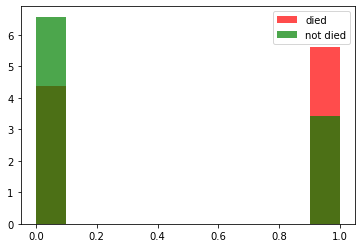

In [343]:
plot_col_deaths_hist('USMER')

**Observation:** Patients treated in medical units of the third level are at risk.

# Column `MEDICAL_UNIT`

In [344]:
df['MEDICAL_UNIT'].value_counts()

12    591811
4     307177
6      37868
9      37384
3      18660
8      10097
10      7543
5       7062
11      5556
7        871
13       813
2        159
1        151
Name: MEDICAL_UNIT, dtype: int64

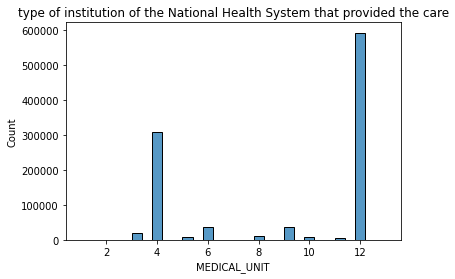

In [345]:
plot_hist_col('MEDICAL_UNIT', 'type of institution of the National Health System that provided the care', kde=False)

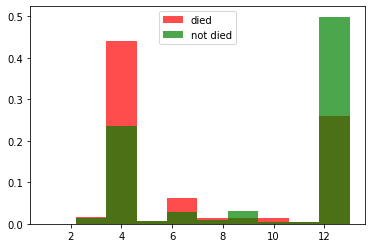

In [346]:
plot_col_deaths_hist('MEDICAL_UNIT')

In [347]:
df = pd.get_dummies(df, columns=['MEDICAL_UNIT'], prefix='MEDICAL_UNIT', prefix_sep='_')
df.head()

,USMER,INTUBED,PNEUMONIA,AGE,DIABETES,COPD,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,...,MEDICAL_UNIT_4,MEDICAL_UNIT_5,MEDICAL_UNIT_6,MEDICAL_UNIT_7,MEDICAL_UNIT_8,MEDICAL_UNIT_9,MEDICAL_UNIT_10,MEDICAL_UNIT_11,MEDICAL_UNIT_12,MEDICAL_UNIT_13
0,0,97,1,65,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,97,1,72,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,55,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,97,0,53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,97,0,68,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Column `INTUBED`

Whether the patient was connected to the ventilator.

In [348]:
df['INTUBED'].value_counts()

97    833253
2     156712
1      33034
99      2153
Name: INTUBED, dtype: int64

In [349]:
df['INTUBED'] = df['INTUBED'].apply(lambda x: 1 if x == 1 else 0)
df['INTUBED'].value_counts()

0    992118
1     33034
Name: INTUBED, dtype: int64

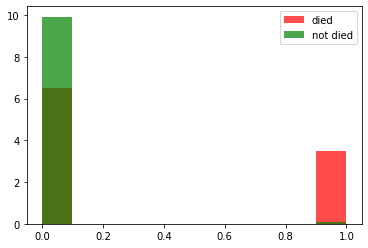

In [350]:
plot_col_deaths_hist('INTUBED')

**Observation**: Patients that had been connected to a ventilator mostly died.

### Column `ICU`

Indicates whether the patient had been admitted to an Intensive Care Unit.

In [351]:
df['ICU'].value_counts()

97    833253
2     173154
1      16434
99      2311
Name: ICU, dtype: int64

In [352]:
df['ICU'] = df['ICU'].apply(lambda x: 1 if x == 1 else 0)
df['ICU'].value_counts()

0    1008718
1      16434
Name: ICU, dtype: int64

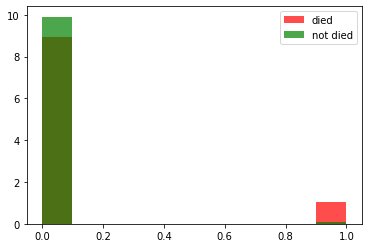

In [353]:
plot_col_deaths_hist('ICU')

**Observation:** Patients that had been admitted to an Intensive Care Unit mostly died.

## Splitting the data

In [354]:
X_cols = [col for col in df.columns if col != 'DIED']

In [355]:
df = df.reset_index()
X, y = df[X_cols].to_numpy(), df['DIED'].to_numpy()
print(X.shape)
print(y.shape)

(1025152, 30)
(1025152,)


In [356]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=75)
X_test, X_valid, y_test, y_valid = train_test_split(X_rest, y_rest, test_size=0.5, random_state=75)

In [357]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(820121, 30) (820121,)
(102515, 30) (102515,)
(102516, 30) (102516,)


In [358]:
df.isnull().any()

index                   False
USMER                   False
INTUBED                 False
PNEUMONIA               False
AGE                     False
DIABETES                False
COPD                    False
INMSUPR                 False
HIPERTENSION            False
OTHER_DISEASE           False
CARDIOVASCULAR          False
OBESITY                 False
RENAL_CHRONIC           False
TOBACCO                 False
CLASIFFICATION_FINAL    False
ICU                     False
DIED                    False
IS_FEMALE               False
HOSPITALIZATION         False
MEDICAL_UNIT_1          False
MEDICAL_UNIT_2          False
MEDICAL_UNIT_3          False
MEDICAL_UNIT_4          False
MEDICAL_UNIT_5          False
MEDICAL_UNIT_6          False
MEDICAL_UNIT_7          False
MEDICAL_UNIT_8          False
MEDICAL_UNIT_9          False
MEDICAL_UNIT_10         False
MEDICAL_UNIT_11         False
MEDICAL_UNIT_12         False
MEDICAL_UNIT_13         False
dtype: bool

## Model evaluation helpers

In [359]:
def eval_model(evaluator, xs, ys):
  y_pred = evaluator.predict(xs)
  precission, recall, fscore, _ = precision_recall_fscore_support(y_true=ys, y_pred=y_pred, average='macro')
  score = model.score(xs, ys)
  print(f'precission: {precission}')
  print(f'recall    : {recall}')
  print(f'fscore    : {fscore}')
  print(f'score     : {score}')

## Models

### Logistic Regression

In [360]:
model = Pipeline([('scaler', StandardScaler()), 
                  ('logistic_regression', LogisticRegression())])
model = model.fit(X_train, y_train)
eval_model(model, X_test, y_test)

precission: 0.8386514748780198
recall    : 0.7544618174860582
fscore    : 0.7893377450742247
score     : 0.9497439399112325


### Ridge Classifier

In [361]:
for alpha in [1e2, 1e3, 1e4, 1e5, 1e6]:
  model = Pipeline([('scaler', StandardScaler()), 
                    ('ridge_classifier', RidgeClassifier(alpha=alpha))])
  model = model.fit(X_train, y_train)
  print(f'Alpha = {alpha}')
  eval_model(model, X_valid, y_valid)
  print()

Alpha = 100.0
precission: 0.8643334439659671
recall    : 0.6682746601462055
fscore    : 0.7242407338649692
score     : 0.9456182449568847

Alpha = 1000.0
precission: 0.8643334439659671
recall    : 0.6682746601462055
fscore    : 0.7242407338649692
score     : 0.9456182449568847

Alpha = 10000.0
precission: 0.8643334439659671
recall    : 0.6682746601462055
fscore    : 0.7242407338649692
score     : 0.9456182449568847

Alpha = 100000.0
precission: 0.8652882383759937
recall    : 0.6683167100805024
fscore    : 0.7244410351128017
score     : 0.9456962815560498

Alpha = 1000000.0
precission: 0.884722522773983
recall    : 0.600500805130934
fscore    : 0.648044925819943
score     : 0.9395704085215967



In [362]:
model = Pipeline([('scaler', StandardScaler()), 
                  ('ridge_classifier', RidgeClassifier(alpha=1e5))])
model = model.fit(X_train, y_train)
eval_model(model, X_test, y_test)

precission: 0.8730288430030477
recall    : 0.6735073939833626
fscore    : 0.7307776432918716
score     : 0.9459103545822563


## Gaussian Naive Bayes

In [363]:
model = Pipeline([('scaler', StandardScaler()), 
                  ('gnb', GaussianNB())])
model = model.fit(X_train, y_train)
eval_model(model, X_test, y_test)

precission: 0.6753230470830898
recall    : 0.8409860384697304
fscore    : 0.7190678879320676
score     : 0.8855289469833683


## Bernoulli Naive Bayes

In [364]:
model = Pipeline([('scaler', StandardScaler()), 
                  ('bernoulli_nb', BernoulliNB())])
model = model.fit(X_train, y_train)
eval_model(model, X_test, y_test)

precission: 0.7315293288529006
recall    : 0.8654500832503975
fscore    : 0.7781619949236857
score     : 0.9216797541823147


## Decision Tree

In [367]:
model = Pipeline([('scaler', StandardScaler()), 
                  ('decision_tree', DecisionTreeClassifier())])
model = model.fit(X_train, y_train)
eval_model(model, X_test, y_test)

precission: 0.7889135411828697
recall    : 0.7399268051726879
fscore    : 0.7616097185162753
score     : 0.9406135687460372


## Random Forest

In [369]:
model = Pipeline([('scaler', StandardScaler()), 
                  ('random_forest', RandomForestClassifier(n_estimators=100))])
model = model.fit(X_train, y_train)
eval_model(model, X_test, y_test)

precission: 0.8055438189547837
recall    : 0.7568582539960381
fscore    : 0.7786065698141142
score     : 0.9445447007754962


## Gradient Boosting

In [371]:
model = Pipeline([('scaler', StandardScaler()), 
                  ('gradient_boost', GradientBoostingClassifier(n_estimators=100))])
model = model.fit(X_train, y_train)
eval_model(model, X_test, y_test)

precission: 0.8455935447512031
recall    : 0.766873243455906
fscore    : 0.8001246389196318
score     : 0.9517631566112277
